### Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Файл с данными за 2016 год: /datasets/games.csv

### Описание данных
#Name — название игры
#Platform — платформа
#Year_of_Release — год выпуска
#Genre — жанр игры
#NA_sales — продажи в Северной Америке (миллионы проданных копий)
3EU_sales — продажи в Европе (миллионы проданных копий)
#JP_sales — продажи в Японии (миллионы проданных копий)
#Other_sales — продажи в других странах (миллионы проданных копий)
#Critic_Score — оценка критиков (максимум 100)
#User_Score — оценка пользователей (максимум 10)
#Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Всю работу можно моделить на несколько шагов:
1. [Знакомство с данными](#1)
2. [Подготовка данных](#2)
3. [Исследовательский анализ данных](#3)
4. [Составление портрета пользователя каждого региона](#4)
5. [Проверка гипотез](#5)
6. [Вывод](#6)

### Шаг  1. Знакомство с данными
## 1 

In [29]:
import pandas as pd
import datetime
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st

In [30]:
games = pd.read_csv('/datasets/games.csv')
display(games.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [31]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


На этапе знакомства с данными подключили библиотеки, которые понадобятся в дальнейшей работе над проектом. Были плучены данные из файла /datasets/games.csv, а также описание этих данных и полей таблицы.

### Шаг  2. Подготовка данных
## 2

#### Изменение названия полей таблицы

In [32]:
games.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 
                 'other_sales', 'critic_score', 'user_score', 'rating']

#### Обработка пропусков в данных

In [33]:
#функция для нахождения полей с пропущенными значениями
def field_nun(data):  
    columns = data.columns
    print('{:<20} {:<}'.format('Поле', 'Количество пропусков'))
    print()
    for i in columns:
        empty_count = data.loc[data[i].isnull()]['platform'].count()
        if empty_count != 0:
            print('{:<20} {:<5}'.format(i, empty_count))


field_nun(games)

Поле                 Количество пропусков

name                 2    
year_of_release      269  
genre                2    
critic_score         8578 
user_score           6701 
rating               6766 


In [34]:
# удаление записей, отсутсвует название игры
games.dropna(subset = ['name'], inplace = True)

# замена пропусков в поле year_of_release на среднее по полю
games['year_of_release'] = games['year_of_release'].fillna(round(games['year_of_release'].median()))

# замена пропусков в поле critic_score на 0
# games['critic_score'] = games['critic_score'].fillna(0)

# замена пропусков в поле rating на RP
games['rating'] = games['rating'].fillna('RP')

# замена пропусков и значений tbd  в поле user_score на 0
# games.loc[(games['user_score'].isnull()) | (games['user_score'] == 'tbd'), 'user_score'] = 0
games['user_score'] = pd.to_numeric(games['user_score'], errors = 'coerce')

Была написана функция field_nun, которая определила поля, в которых есть пропуски значений. Из поля name были удалены строки с пропускасми, так как мы оцениваем рейтинг отдельных игр, но если мы не знаем названия игры, анализ не имеет смысла. Пропуски в поле year_of_release заменили на среднее по полю, так как разброс значений маленький. В полях critic_score и user_score пустые значения заменили на 0, так как пустое значение в одном из этих полей связано с тем, что рейтинг ещё не оценен. Значения tbd в поле user_score также были заменены на 0, ибо tbd означает To Be Determined, то есть "Будет определено". Пропуски в поле rating были заменены на RP, так как NaNs могут означать, что рейтинг ещё не определен.

#### Удаление дубликатов

In [35]:
games = games.drop_duplicates().reset_index(drop = True)

#### Преобразуйте данные в нужные типы

In [36]:
# список с полями, которые приводятся к int
float_types_list = ['year_of_release', 'critic_score']

# цикл, которая огругляет значение до целого, а потом приводит к int
for i in float_types_list:   
    games[i] = games[i].astype('int', errors = 'ignore')

# изменение типа поля user_score с object на float
games['user_score'] = pd.to_numeric(games['user_score'])

Поля year_of_release и critic_score были приведены к типу int, так как значения хранились целыми, но с 0 после запятой. Поле user_score стало числовым.

#### Расчет суммарных продаж во всех регионах 

In [37]:
# функция для подсчета продаж игры по всему миру
def total_sales_func(data): 
    data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

total_sales_func(games)

Получено новое поле total_sales с суммой продаж с каждого региона

### Шаг  3. Исследовательский анализ данных
## 3

#### Рассмотрение выпуска игр по годам

2007    1466
2008    1427
2009    1426
2010    1255
2011    1136
Name: year_of_release, dtype: int64

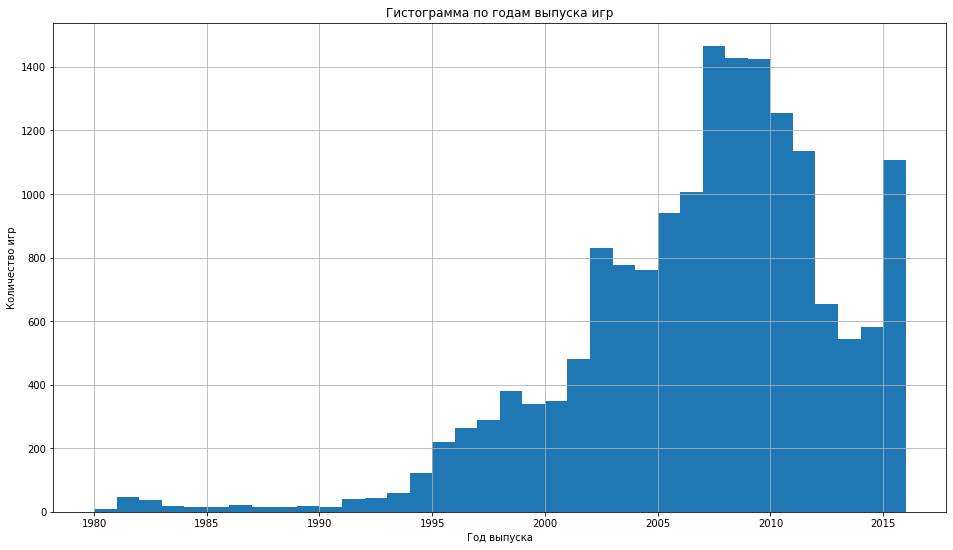

In [38]:
# получение годов с свмым большим количеством выпуска игр
display(games['year_of_release'].value_counts().head())

# построение гистограммы по годам выпуска игр
games.hist('year_of_release', bins = 36, figsize = (16, 9))
plt.title('Гистограмма по годам выпуска игр')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.show()

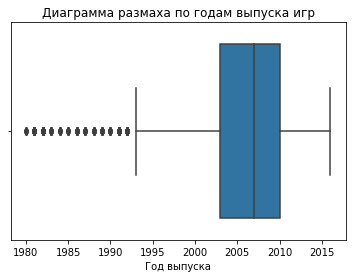

In [39]:
# построение диаграммы размаха по годам выпуска игр
sns.boxplot(games['year_of_release'])
plt.title('Диаграмма размаха по годам выпуска игр')
plt.xlabel('Год выпуска')
plt.show()

Из полученной информации делаем вывод, что до 1996 года игры выпускались достаточно редко. Следовательно, можем отбросить эту часть данных. Новый датасет будет содержать данные за 20 лет(1996-2016)

#### Исследование изменчивости продаж по отдельным платформам

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


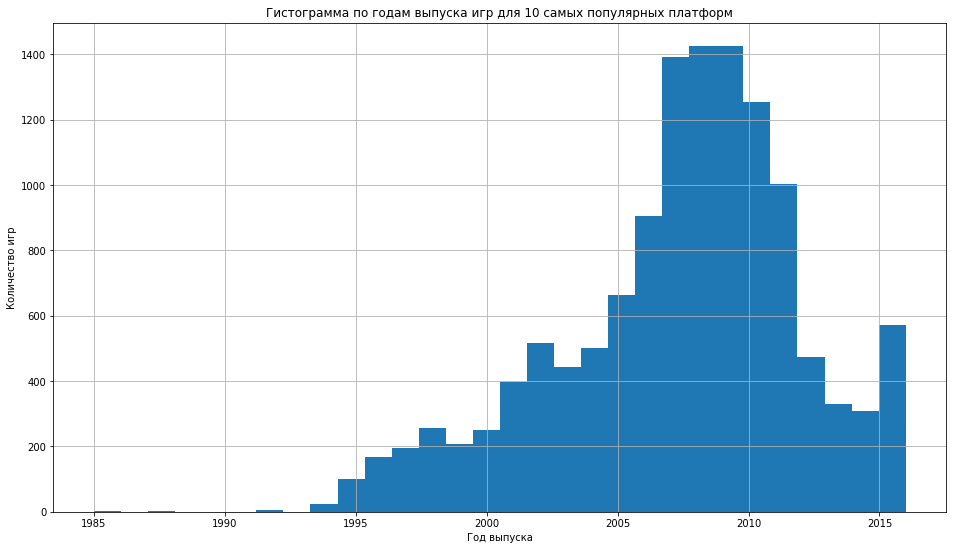

In [40]:
# получение 10 платформ-лидеров по количеству продаж игр
top_10_pltaform = \
        games.groupby('platform')[['platform','total_sales']].sum().sort_values(by = 'total_sales', ascending = False).head(10)
top_10_platform_games = games.loc[games['platform'].isin(top_10_pltaform.index)]
display(top_10_pltaform)

# построение гистограммы по годам выпуска игр для 10 самых популярных платформ
top_10_platform_games.hist('year_of_release', bins = 30, figsize = (16, 9))
plt.title('Гистограмма по годам выпуска игр для 10 самых популярных платформ')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.show()

Получена сводная таблица с информацией о 10 платформах с наибольшим количеством продаж. Лидером является РS2. По гистограмме таблицы top_10_platform_games можно заметить что её форма почти не изменилось, только отбросилось большое количесвто игр выпущенных ранее 1996 года.

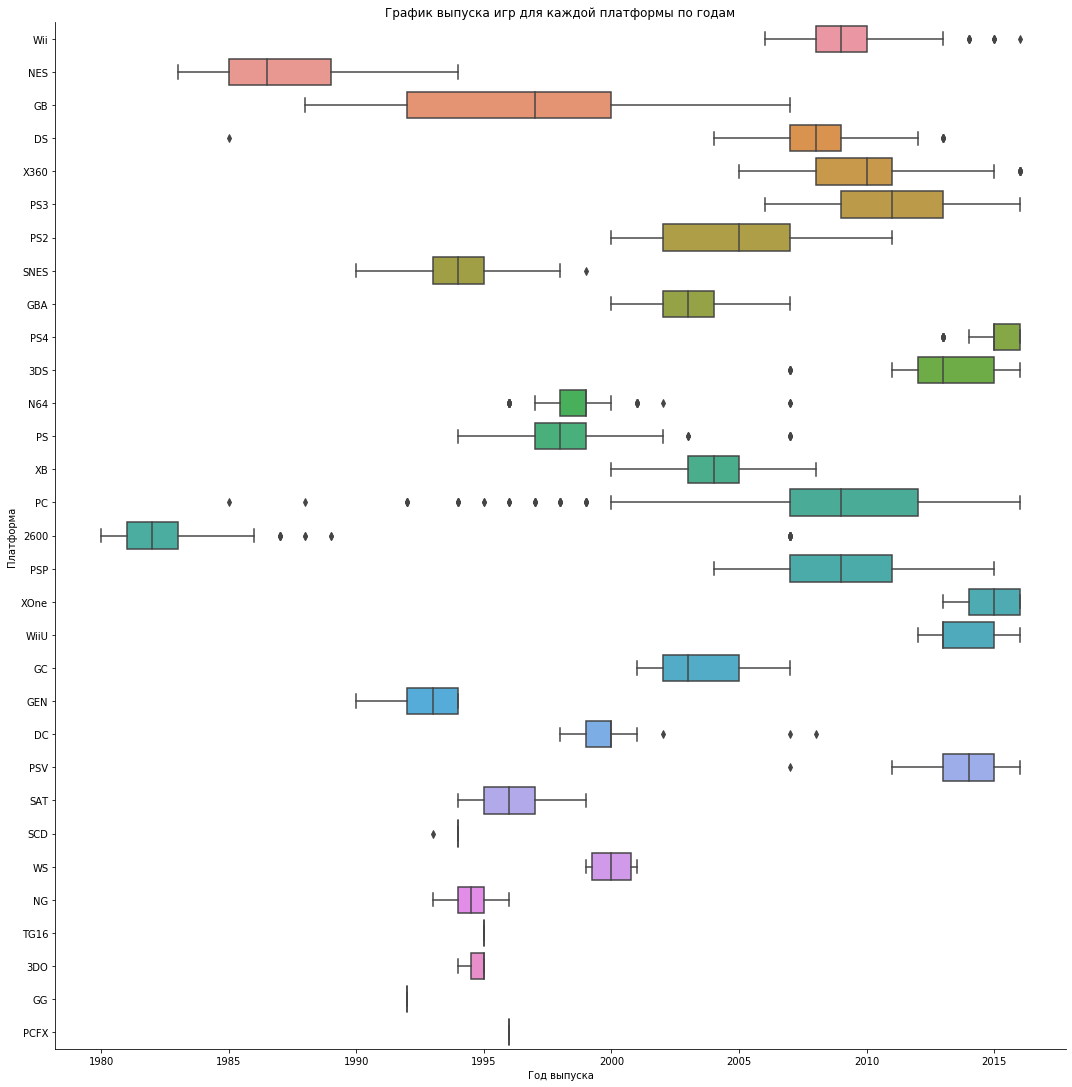

In [41]:
# получение графика выпуска игр по годам по каждой платформе
sns.catplot(x = 'year_of_release', y = 'platform', data = games, height= 15, kind = 'box')
plt.title('График выпуска игр для каждой платформы по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Платформа')
plt.show()

По полученному catplot можем сделать вывод, что большинство платформ выпускают игры не больше 10 лет, чеще всего это диапозон 3-7 лет. Но есть такие платформы PC и GB, которые были популярны или ещё популярны более 20 лет, это не уидительно, ибо каждый кто родился 1990 - 2000 годах хотя бы слышал про GameBoy и обычный компьютер. Так же мы видим, что есть платформы, которые существовали менее 3 лет(GG, 3D0, PCFX и др.)

#### Выбор данных за актуальный период для дальнейшего анализа

In [43]:
# получение выборки данных исходя из года выпуска игры, 2013 год и моложе
games = games.query('year_of_release > 2013')
display(games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,RP,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,RP,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,RP,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16701,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,RP,0.01
16705,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,RP,0.01
16708,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,RP,0.01
16710,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,RP,0.01


Были отобраны данные по выпуску игр от 2005 года и моложе по причине того, что большинство платформ, которые выпускали игры продолжительные сроки находятся в правой части catplot. Кроме того, часть итих платформ выпускает игры и по сей день. Следовательно, это будет актуальнее для анализа для 2017 года.

#### Выбор потенциально прибыльных платформ

In [44]:
# получение топ 5 прибыльных платформ
display(games.groupby('platform')['total_sales'].sum().sort_values(ascending = False).head())

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
Name: total_sales, dtype: float64

По продажам лидируют 5 платформ: PS4, X360, PS3, XOne, 3DS.

Хоть и и были получены платформы-лидеры по продажам, но потенциально прибыльными их всех назвать нельзя, ибо релизы игр на эти некоторые платформы были более 5 лет назад.

К потенциально прибыльным платформам я отнес те, на которые были релизы игр от 2014 года по 2016 год. 
###### А именно:
    1. PS4
    2. 3DS
    3. PC
    4. XONE
    5. WiiU
    6. PSV

#### Количество глобальных продаж игр по отдельным платформам

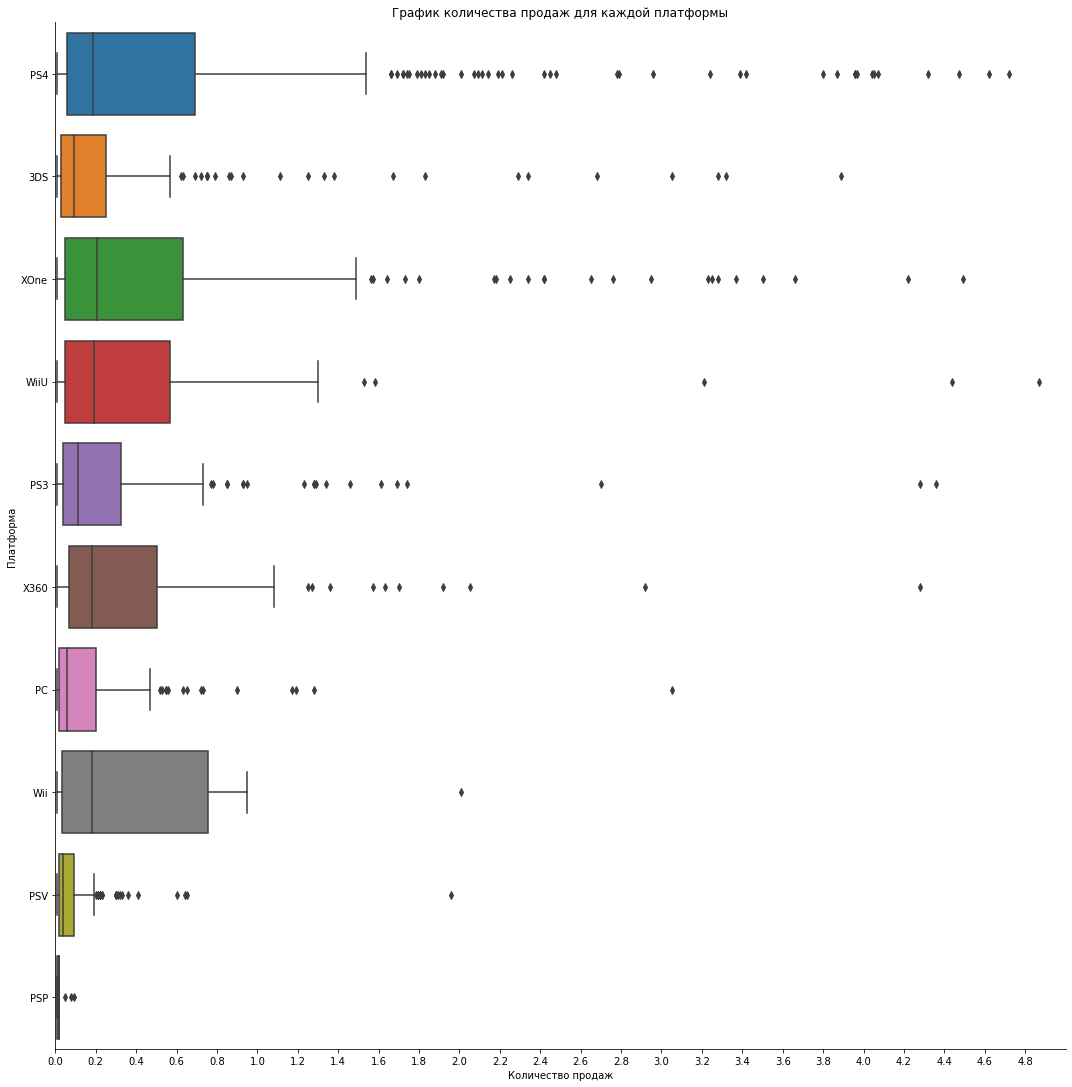

In [46]:
# получение диаграммы размаха по количеству продаж для каждой платформы отдельно
sns.catplot(x = 'total_sales', y = 'platform', data = games, height= 15, kind = 'box')
plt.xlim([0, 5])
plt.xticks(np.arange(0,5,0.2))
plt.title('График количества продаж для каждой платформы')
plt.xlabel('Количество продаж')
plt.ylabel('Платформа')
plt.show()

По полученным диаграммам размаха можно сказать, что лидером продаж являются игры на платформу  PS4, PS3, X360, XONE. Почти у каждой платформы есть игры с выбрасными значениями по продажам, как в сторону 0, то есть игры были совсем плохими, так и в сторону больших значений, то есть, которые обрели популярность.

#### Влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков

Как популярная платформа была выбрана PS4, так как она является одним из лидеров по продажам и лидером выпуска игр в период 2014 - 2016.

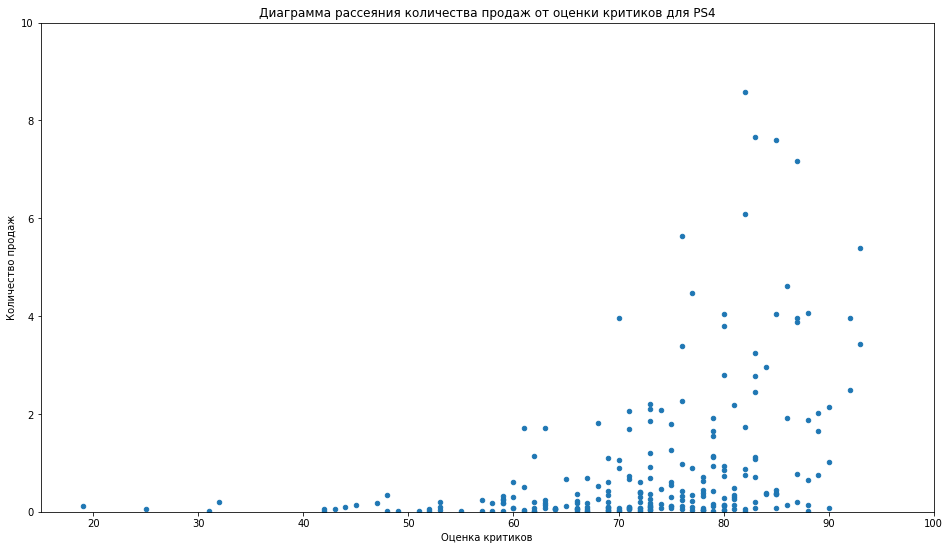

Коэфициент корреляции - 0.40


In [47]:
# получение выборки только для платформы PS4
PS4 = games.query('platform == "PS4"')

# построение диаграммы рассеяния количества продаж от оценки критиков для PS4
PS4.plot(x = 'critic_score', y = 'total_sales', kind = 'scatter',xlim = (15, 100), ylim = (0, 10), figsize = (16,9))
plt.title('Диаграмма рассеяния количества продаж от оценки критиков для PS4')
plt.xlabel('Оценка критиков')
plt.ylabel('Количество продаж')
plt.show()

# расчет коэфициента корреляции
print('Коэфициент корреляции - {:.2f}'.format(PS4[['critic_score', 'total_sales']].corr()['total_sales'][0]))

Из диаграммы рассеяния и коэфициента корреляции мы видим, что есть слабая положительная зависимость количества продаж от оценки критиков.

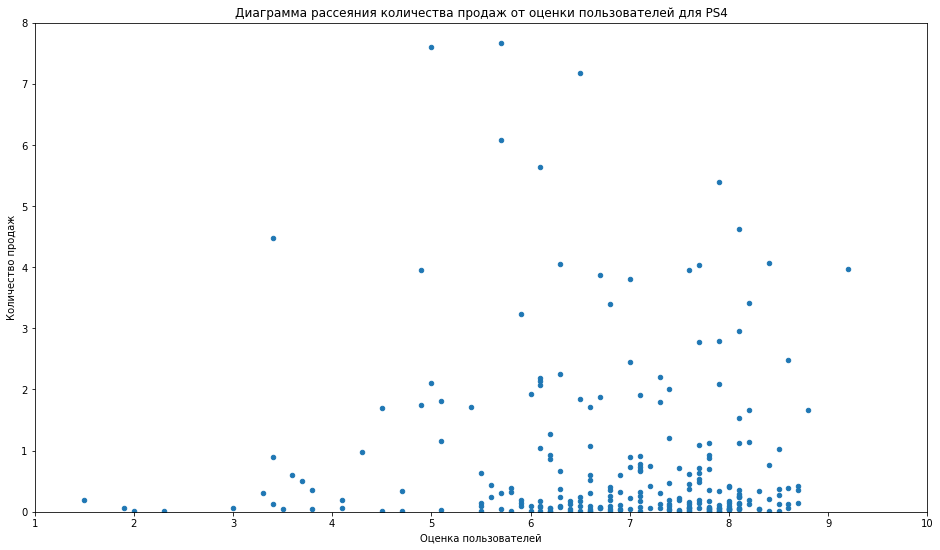

Коэфициент корреляции - -0.04


In [48]:
# построение диаграммы рассеяния количества продаж от оценки пользователей для PS4
PS4.plot(x = 'user_score', y = 'total_sales', kind = 'scatter',xlim = (1, 10),ylim = (0, 8),  figsize = (16,9))
plt.title('Диаграмма рассеяния количества продаж от оценки пользователей для PS4')
plt.xlabel('Оценка пользователей')
plt.ylabel('Количество продаж')
plt.show()

# расчет коэфициента корреляции
print('Коэфициент корреляции - {:.2f}'.format(PS4[['user_score', 'total_sales']].corr()['total_sales'][0]))

Из диаграммы рассеяния и коэфициента корреляции мы видим, что есть слабая положительная зависимость количества продаж от оценки пользователей. Эта зависимость меньше слабее зависимости количества продаж от оценки критиков.

#### Сравнение выводов для PS4 c выводами по остальным платформам

Для этого сравнения будет достаточно получить коэфициенты корреляии количества продаж и оценок критиков и пользователей.

In [49]:
# получение выборки по остальным платформам
other_platforms = games.query('platform != "PS4"')

# расчет коэфициентов корреляции
print('Коэфициент корреляции количества продаж и оценки пользователей - {:.2f}'.format(other_platforms[['user_score', 'total_sales']].corr()['total_sales'][0]))
print('Коэфициент корреляции количества продаж и оценки критиков - {:.2f}'.format(other_platforms[['critic_score', 'total_sales']].corr()['total_sales'][0]))

Коэфициент корреляции количества продаж и оценки пользователей - -0.02
Коэфициент корреляции количества продаж и оценки критиков - 0.31


Из коэфициентов корреляции можно сделать вывод, что оценки пользователей никак не влияют на продажи, в то время как корреляция от оценки критиков равно 0.31, это не мало.

#### Общее распределение игр по жанрам и продажи с ориентацией на жагры игр

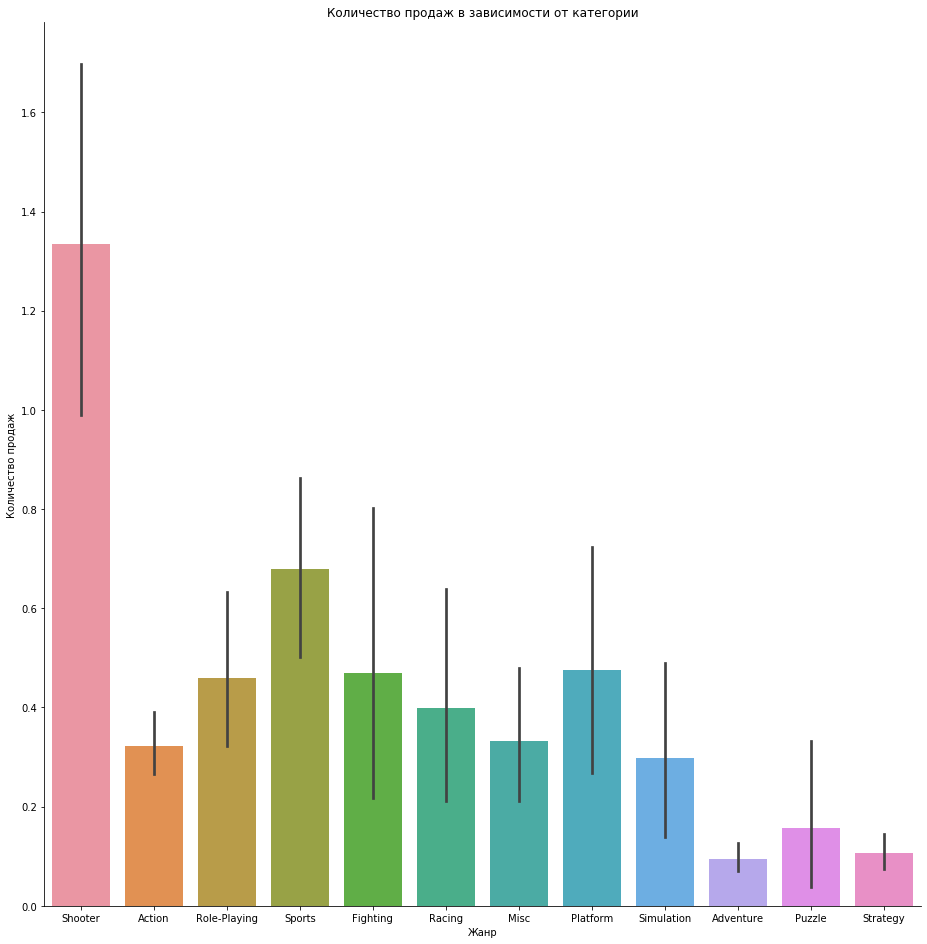

In [50]:
# получение графика количества продаж в зависимости от категории
sns.catplot(data = games, x = 'genre', y = 'total_sales', kind = 'bar', aspect = 1, height = 13)
plt.title('Количество продаж в зависимости от категории')
plt.xlabel('Жанр')
plt.ylabel('Количество продаж')
plt.show()

По полученному столбчатому графику делавем вывод, что самыми популярными жанрами являются Shooter, Sports. Самым не популярными явлются Strategy и  Adventure.

### Шаг  4. Составление портрета пользователя каждого региона
## 4

In [51]:
# функция получения топ 5 популярных платформ
def platform_region(region):
    region_sales = games[region].sum()
    top_5_platforms = games[['platform', region]].groupby('platform').sum().sort_values(by = region, ascending = False)
    top_5_platforms[region] = round(top_5_platforms[region] / region_sales, 2)
    return top_5_platforms.head()

# функция получения топ 5 популярных жанров
def genre_region(region):
    top_5_genre = games[['genre', region]].groupby('genre').sum().sort_values(by = region, ascending = False).head()
    return top_5_genre

# функция получения топ 5 популярных рейтингов
def rating_region(region):
    top_5_rating = games[['rating', region]].groupby('rating').sum().sort_values(by = region, ascending = False).head()
    return top_5_rating

# функция вывода таблиц популярности
def pop_print(region):
    print('Cамые популярные платформы')
    display(platform_region(region))
    print()
    print()
    print('Cамые популярные жанры')
    display(genre_region(region))
    print()
    print()
    print('Самые популярные рейтинги')
    display(rating_region(region))

#### Japan

In [52]:
pop_print('jp_sales')

Cамые популярные платформы


,jp_sales
platform,
3DS,0.48
PS4,0.16
PSV,0.16
PS3,0.12
WiiU,0.08




Cамые популярные жанры


,jp_sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87




Самые популярные рейтинги


,jp_sales
rating,
RP,56.90
T,14.78
E,8.94
M,8.01
E10+,4.46


#### Europe

In [53]:
pop_print('eu_sales')

Cамые популярные платформы


,eu_sales
platform,
PS4,0.48
XOne,0.17
PS3,0.09
PC,0.07
3DS,0.06




Cамые популярные жанры


,eu_sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13




Самые популярные рейтинги


,eu_sales
rating,
M,93.44
RP,58.95
E,58.06
T,34.07
E10+,26.16


#### North America

In [54]:
pop_print('na_sales')

Cамые популярные платформы


,na_sales
platform,
PS4,0.35
XOne,0.29
X360,0.10
3DS,0.08
PS3,0.08




Cамые популярные жанры


,na_sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05




Самые популярные рейтинги


,na_sales
rating,
M,96.42
RP,64.72
E,50.74
T,38.95
E10+,33.23


По полученным таблицам популярности можно сделать вывод, что европейские и американские предпочтения в выборе платформ не особо отличаются, различия есть в порядке исходя из долей продаж, но топ 4 такой же, с жанрам ситуация похожая. Но вот с Японией есть большие различия. У японцев в топ входят такие платформы как PSP, WiiU и в  жанрах первое место занимает Role-Playing.

По рейтингу ESRB во всех регионах ситация похожая, но с небольшими отличиями. На первом месте в Европе и СА 18+, вторые и третьи места занимают 0+ и 13+, также в топе есть 10+, когда как в Японии на первом месте игры с возрастной категорией 13+. RP означает, что рейтинг ещё не определен.

### Шаг  5. Проверка гипотез
## 5

#### Гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC

Нулевая гипотеза: среднии пользовательские рейтинги платформ Xbox One и PC одинаковы

Альтернативная гипотеза: среднии пользовательские рейтинги платформ Xbox One и PC разные

##### Расчет дисперсий

In [55]:
xbox_data = games.query('platform == "XOne"')
pc_data = games.query('platform == "PC"')
xbox_variance = np.var(xbox_data['user_score']) 
pc_variance = np.var(pc_data['user_score']) 
print('Дисперсия xbox - ', xbox_variance)
print('Дисперсия pc - ', pc_variance)

Дисперсия xbox -  1.879546005509642
Дисперсия pc -  2.8773743617307175


Дисперсии выборок нельзя считать равными. Следовательно, equal_var = False.

In [56]:
# критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
alpha = 0.05

results = st.ttest_ind(xbox_data['user_score'].dropna(), pc_data['user_score'].dropna(), equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.11601398086668827
Не получилось отвергнуть нулевую гипотезу


Не можем овергнуть гипотезу: среднии пользовательские рейтинги платформ Xbox One и PC одинаковы.

#### Гипотеза о различии средних пользовательских рейтингов жанров Action и Sports

Нулевая гипотеза: среднии пользовательские рейтинги жанров Action и Sports одинаковы

Альтернативная гипотеза: среднии пользовательские рейтинги жанров Action и Sports различны.

##### Расчет дисперсий

In [57]:
action_data = games.query('genre == "Action"')
sports_data = games.query('genre == "Sports"')
action_variance = np.var(action_data['user_score']) 
sports_variance = np.var(sports_data['user_score']) 
print('Дисперсия action - ', action_variance)
print('Дисперсия sports - ', sports_variance)

Дисперсия action -  1.89208448117539
Дисперсия sports -  3.419837559675119


Дисперсии выборок нельзя считать равными. Следовательно, equal_var = False.

In [58]:
# критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
alpha = 0.05

results = st.ttest_ind(action_data['user_score'].dropna(), sports_data['user_score'].dropna(), equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Не можем отвергать гипотезу: среднии пользовательские рейтинги жанров Action и Sports одинаковы. 

### Шаг  6. Вывод
## 6